# Desvanecimiento del gradiente

[The Vanishing Gradient Problem](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484)

**Problema**

Para funciones de activación, cuya derivada se acerca a cero, conforme se agregan capas a la red neuronal este se vuelve más y más difícil de entrenar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def sigma(z):
    return 1 / (1 + np.exp(-z))

In [3]:
def derivada_sigma(z):
    a = sigma(z)
    return a * (1 - a)

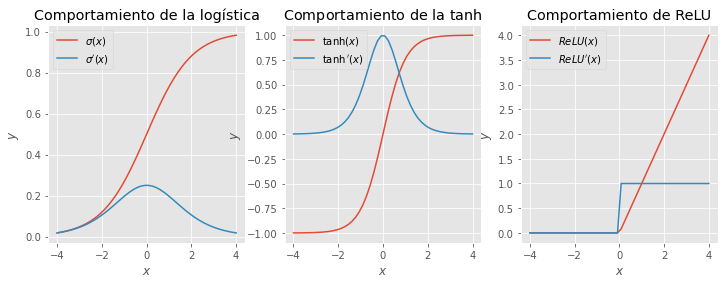

In [4]:
def grafica_activación():
    x = np.linspace(-4,4)
    s = sigma(x)
    ds = derivada_sigma(x)
    
    t = np.tanh(x)
    dt = 1 - t**2
    
    r = np.maximum(0,x)
    dr = np.heaviside(x, 0)
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    axes[0].plot(x, s, label="$\\sigma(x)$")
    axes[0].plot(x, ds, label="$\\sigma'(x)$")
    axes[0].set_title("Comportamiento de la logística")
    axes[1].plot(x, t, label="$\\tanh(x)$")
    axes[1].plot(x, dt, label="$\\tanh'(x)$")
    axes[1].set_title("Comportamiento de la $\\tanh$")
    axes[2].plot(x, r, label="$ReLU(x)$")
    axes[2].plot(x, dr, label="$ReLU'(x)$")
    axes[2].set_title("Comportamiento de ReLU")
    for i in range(3):
        axes[i].legend()
        axes[i].set_xlabel("$x$")
        axes[i].set_ylabel("$y$")
grafica_activación()

Los algoritmos de optimización basados en el gradiente comparten la idea escencial del descenso por el gradiente:
\begin{align}
 W_{t+1} = W_t - \alpha \nabla_W J
\end{align}
donde $J$ es la función de error y $W$ los pesos.

Recordando que para calcular el gradiente con respecto a cada capa de pesos éste es proporcional a:
 \begin{align}
  \Delta^{(l-1)} &= \Delta^{(l)}\left(W^{(l-1)}\right)^T \circ g'(Z^{(l-1)})
 \end{align}

tenemos que, entre más capas, más veces aparece el término $g'(Z^{(l-1)})$, de modo que para la primer capa:

\begin{align}
  \Delta^{(1)} &\propto g'(Z^{(0)}) \circ g'(Z^{(1)}) \circ ... \circ g'(Z^{(L-1)})
\end{align}

siendo todos estos números $\ll 1$.

De este modo, al sustituir el valor de un gradiente muy pequeño en la fórmula de entrenamiento, los pesos prácticamente no cambian, independientemente de qué tan grande sea la magnitud del valor de entrada.

## Ejemplo

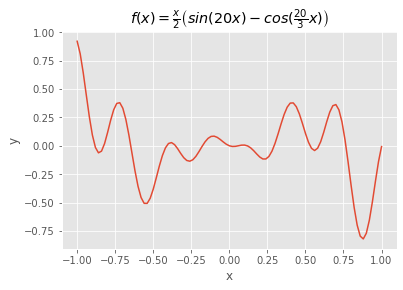

In [5]:
def grafica_ejemplo():
    """
    Muestra la gráfica de la función que tratamos de aproximar
    """
    x = np.arange(-1,1.02,0.02)
    plt.plot(x, x/2 * (np.sin(20*x) - np.cos(20*x/3)))
    plt.title('$f(x) = \\frac{x}{2} \\left( sin(20x) - cos(\\frac{20}{3}x) \\right)$')
    plt.xlabel('x')
    plt.ylabel('y')
grafica_ejemplo()

In [6]:
import torch
from torch import nn

In [7]:
X = torch.arange(-1.,1.02,0.02)  # Tensor 1D
X = torch.reshape(X, (len(X),1))

In [8]:
def f(x):
    """
    Función objetivo.
    """
    return x/2 * (torch.sin(20*x) - torch.cos(20*x/3))

In [9]:
# Calculamos los valores de la función que queremos aproximar
# para las entradas X

with torch.no_grad():
    Y = f(X)

In [10]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, s, f_activacion=nn.Sigmoid):
        """
        param s: Lista de número de neuronas en las capa ocultas
        """
        super(DeepNeuralNetwork, self).__init__()
        
        # Primer capa oculta:
        componentes = [nn.Linear(1,s[0]), f_activacion()]
        
        # Demás capas ocultas:
        for i in range(1,len(s)):
            componentes.append(nn.Linear(s[i-1],s[i]))
            componentes.append(f_activacion())
        
        # Capa de salida
        componentes.append(nn.Linear(s[-1],1))
        componentes.append(f_activacion())
        
        # Arma perceptrón multicapa
        self.layers_stack = nn.Sequential(*componentes)
        
    def forward(self, x):
        """
        Evaluación de la red sobre la entrada x
        usando alimentación hacia adelante para los pesos
        actuales.
        """
        logits = self.layers_stack(x)
        return logits

In [11]:
model = DeepNeuralNetwork([3] * 7)

In [12]:
# Calcularemos el gradiente de la diferencia al cuadrado
loss_fn = nn.MSELoss()

In [13]:
# Evaluamos la función de la red con encadenamiento hacia adelante
Y_ = model(X)

# Evaluamos el error
loss = loss_fn(Y, Y_)

# Limpiamos tensores para gradientes
model.zero_grad()

# Solicitamos el cálculo del gradiente del error
loss.backward()

In [14]:
# Parámetros entrenables de la red
params = list(model.parameters())

In [15]:
# Cada componente del gradiente, que acaba de ser
# calculado, con respecto
# a un parámetro se encuentra almacenado al
# lado del tensor que contiene al parámetro.

for t in params:
    print("Parámetro: ")
    print(t)
    print("Gradiente: ")
    print(t.grad)
    print()

Parámetro: 
Parameter containing:
tensor([[-0.3747],
        [ 0.3810],
        [ 0.8487]], requires_grad=True)
Gradiente: 
tensor([[-2.9598e-08],
        [-4.4662e-09],
        [-1.0860e-08]])

Parámetro: 
Parameter containing:
tensor([ 0.5580, -0.8845, -0.2833], requires_grad=True)
Gradiente: 
tensor([-2.4753e-07, -3.0874e-08, -9.2564e-08])

Parámetro: 
Parameter containing:
tensor([[ 0.5251, -0.1779, -0.2642],
        [-0.4621, -0.0953, -0.4137],
        [-0.5315,  0.3036, -0.3229]], requires_grad=True)
Gradiente: 
tensor([[-5.3400e-07, -2.5634e-07, -3.8342e-07],
        [ 1.1432e-06,  5.4975e-07,  8.2295e-07],
        [-2.5947e-07, -1.2478e-07, -1.8678e-07]])

Parámetro: 
Parameter containing:
tensor([-0.3422,  0.5498,  0.0545], requires_grad=True)
Gradiente: 
tensor([-8.5147e-07,  1.8239e-06, -4.1399e-07])

Parámetro: 
Parameter containing:
tensor([[-0.4503, -0.1407,  0.1792],
        [-0.2964,  0.4519, -0.1615],
        [ 0.0518,  0.3945, -0.0757]], requires_grad=True)
Gradiente:

In [16]:
def linealiza_params(params):
    params_list = []
    grad_list = []
    for t in params:
        nparams = torch.reshape(t, (-1,)).detach().numpy()
        for p in nparams:
           params_list.append(p)
        ngrads = torch.reshape(t.grad, (-1,)).detach().numpy()
        for g in ngrads:
            grad_list.append(g)
    return params_list, grad_list

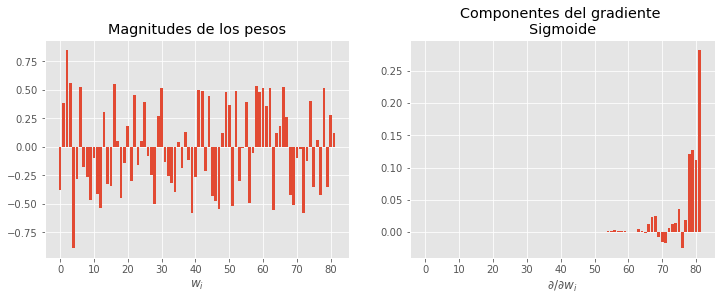

In [17]:
def plot_magnitudes(params, f_act_name="Sigmoide"):
    """
    Graficamos el valor de gradiente para cada capa
    """
    params_list, grad_list = linealiza_params(params)
    x = np.arange(len(params_list))
    
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].bar(x, params_list)
    axes[0].set_title("Magnitudes de los pesos")
    axes[0].set_xlabel("$w_i$")
    axes[1].bar(x, grad_list)
    axes[1].set_title(f"Componentes del gradiente \n{f_act_name}")
    axes[1].set_xlabel("$\partial /\partial w_i$")
plot_magnitudes(params)

# Otras funciones de activación

In [18]:
# Versión interactiva
from ipywidgets import interact_manual
import ipywidgets as widgets

In [23]:
modelo_experimento = None
fs_activacion = {"Tanh": nn.Tanh,
                 "LogSigmoid": nn.LogSigmoid,
                 "ReLU": nn.ReLU,
                 "LeakyReLU": nn.LeakyReLU,
                 "Sigmoid": nn.Sigmoid
                }
@interact_manual(
    activacion_nombre = widgets.SelectionSlider(
        options = ["Tanh",
                   "LogSigmoid",
                   "ReLU",
                   "LeakyReLU",
                   "Sigmoid"
                  ]
    )
)
def experimenta(activacion_nombre):
    global modelo_experimento
    modelo_experimento = model = DeepNeuralNetwork([3] * 7, fs_activacion[activacion_nombre])
    
    # Evaluamos la función de la red con encadenamiento hacia adelante
    Y_ = model(X)

    # Evaluamos el error
    loss = loss_fn(Y, Y_)

    # Limpiamos tensores para gradientes
    model.zero_grad()

    # Solicitamos el cálculo del gradiente del error
    loss.backward()
    
    plot_magnitudes(list(model.parameters()), activacion_nombre)

interactive(children=(SelectionSlider(description='activacion_nombre', options=('Tanh', 'LogSigmoid', 'ReLU', …

# Tras el entrenamiento

La siguiente celda permite entrenar el modelo y visualizar qué pasa con los pesos y los gradientes

In [20]:
import math

In [24]:
def train(X, Y, model, learning_rate, num_steps):
    """
    Función que realiza el entrenamiento:
    Intentará reducir la distancia entre los valores que salen
    de la red y lo que deseamos modificando los pesos de la red.
    """
    size = len(X)
    loss_fn = nn.MSELoss()
    # Misma alfa para todos los pesos:
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Utiliza momentos para actualizar alfa
    # sobre parámetros individuales
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    step_report = 100
    num_reports = int(math.ceil(num_steps/step_report))
    e = np.zeros(num_reports)
    for i in range(num_steps):
        # Predicción y error
        Y_hat = model(X)
        loss = loss_fn(Y_hat, Y)
        
        # Reduciendo el error
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Cómo vamos
        if i % step_report == 0:
            num_report = int(i/step_report)
            e[num_report] = loss.item()
            #print(f"{num_report} loss: {loss:>7f}")
    #plt.plot(e)
    return Y_hat, e

In [25]:
@interact_manual(
    pasos = widgets.FloatLogSlider(value=1000,
                                   base=10,
                                   min=3, # min exponent of base
                                   max=5, # min exponent of base
                                   step=0.2), # exponent step, 
)
def experimenta(pasos):
    n_pasos = int(pasos)
    
    global modelo_experimento
    y_pred, e = train(X, Y, modelo_experimento, 0.01, n_pasos)
    y_pred = y_pred.detach().numpy()
    
    params_list, grad_list = linealiza_params(params)
    
    fig, axes = plt.subplots(2, 2, figsize=(12,12))
    axes[0][0].plot(np.arange(len(e))*100,e)
    axes[0][0].set_title("Error vs pasos")
    axes[0][0].set_xlabel('pasos')
    axes[0][0].set_ylabel('error')
    
    axes[0][1].plot(torch.reshape(X, (-1,)).detach().numpy(), y_pred)
    axes[0][1].set_title("$\hat{y}(x)$")
    axes[0][1].set_xlabel('$x$')
    axes[0][1].set_ylabel('$y$')
    
    x = np.arange(len(params_list))
    axes[1][0].bar(x, params_list)
    axes[1][0].set_title("Magnitudes de los pesos")
    axes[1][0].set_xlabel("$w_i$")
    axes[1][1].bar(x, grad_list)
    axes[1][1].set_title(f"Componentes del gradiente")
    axes[1][1].set_xlabel("$\partial /\partial w_i$")

interactive(children=(FloatLogSlider(value=1000.0, description='pasos', max=5.0, min=3.0, step=0.2), Button(de…